CNN

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

# -------------------------
# Config
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = (128, 128)
batch_size = 32
num_epochs = 10

# -------------------------
# Custom Dataset Class
# -------------------------
class LeafDataset(Dataset):
    def __init__(self, base_dir, transform=None, label_map=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.label_map = label_map or {}

        # Label mapping
        classes = sorted(os.listdir(base_dir))
        if not self.label_map:
            self.label_map = {cls_name: idx for idx, cls_name in enumerate(classes)}

        for cls in classes:
            cls_folder = os.path.join(base_dir, cls)
            if not os.path.isdir(cls_folder):
                continue
            for fname in os.listdir(cls_folder):
                img_path = os.path.join(cls_folder, fname)
                self.image_paths.append(img_path)
                self.labels.append(self.label_map[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# -------------------------
# Transforms
# -------------------------
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
])

# -------------------------
# Load Data
# -------------------------
train_dataset = LeafDataset(r"D:\Rice-Disease-Simulation\data\train", transform=transform)
val_dataset = LeafDataset(r"D:\Rice-Disease-Simulation\data\validation", transform=transform, label_map=train_dataset.label_map)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# -------------------------
# CNN Model
# -------------------------
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = CNNModel(num_classes=len(train_dataset.label_map)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# -------------------------
# Training Loop
# -------------------------
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_loader):.4f}")

# -------------------------
# Evaluation
# -------------------------
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\n✅ Classification Report:")
print(classification_report(all_labels, all_preds, target_names=list(train_dataset.label_map.keys())))

print("✅ Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


In [ ]:
pip install torchcam

In [ ]:
from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

In [17]:
target_layer = model.net[3]  # The earlier Conv2d(32, 64, ...)
cam_extractor = GradCAM(model, target_layer=target_layer)

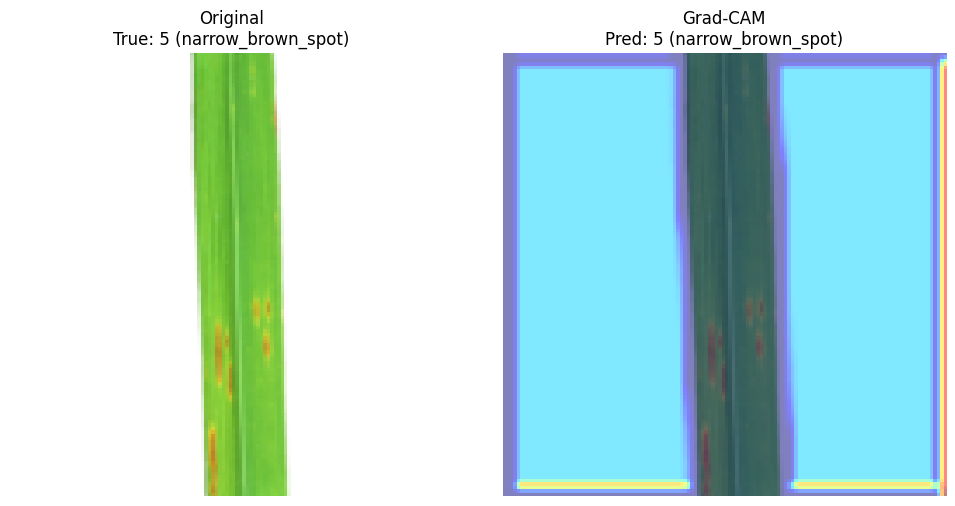

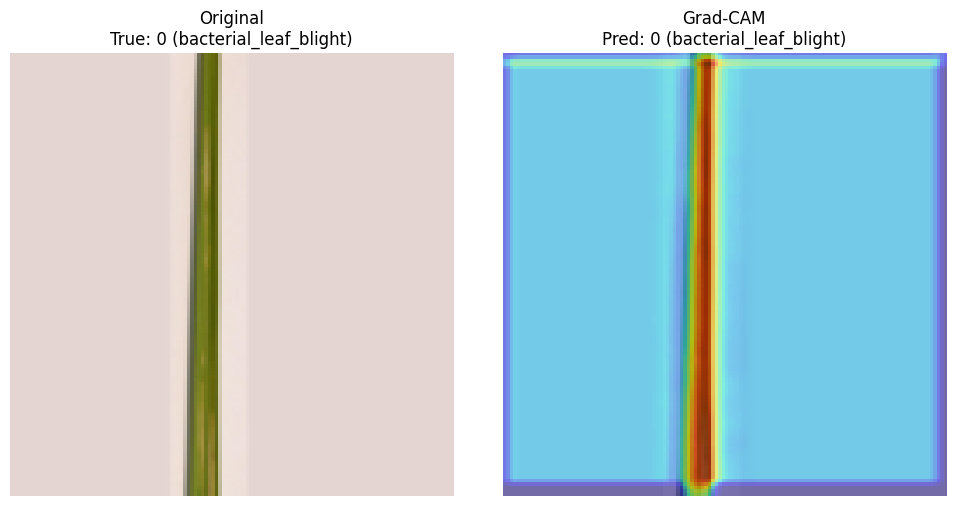

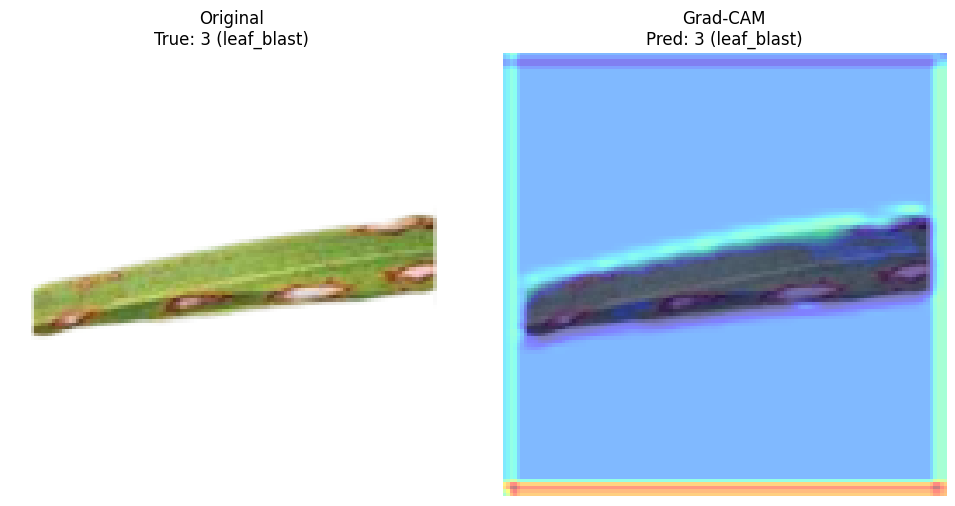

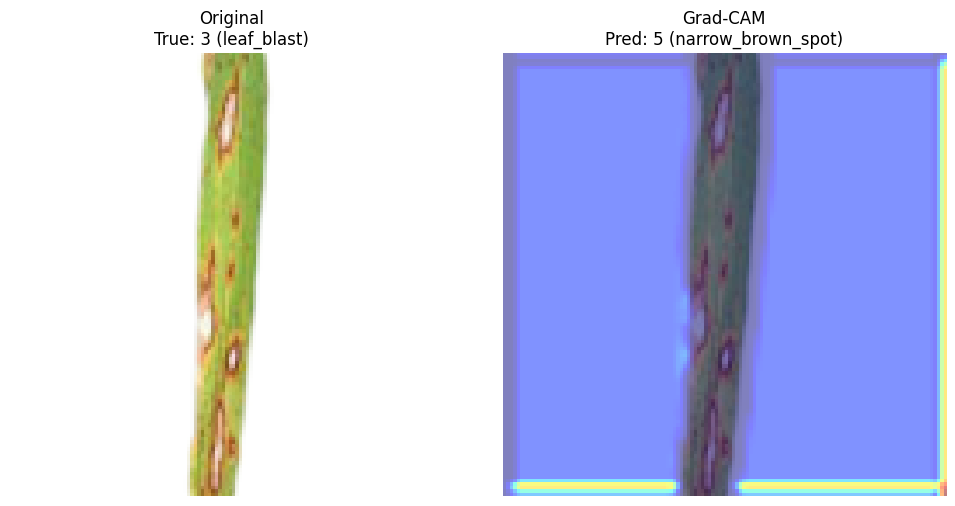

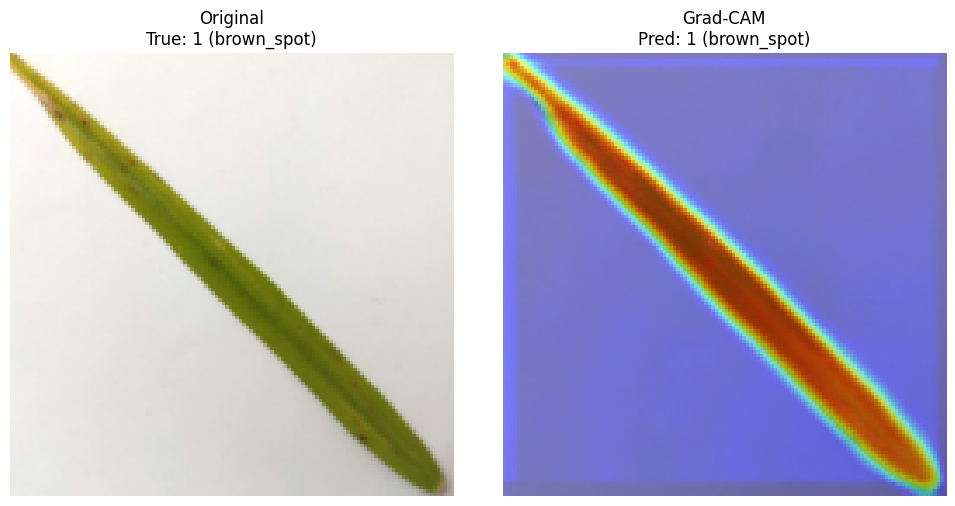

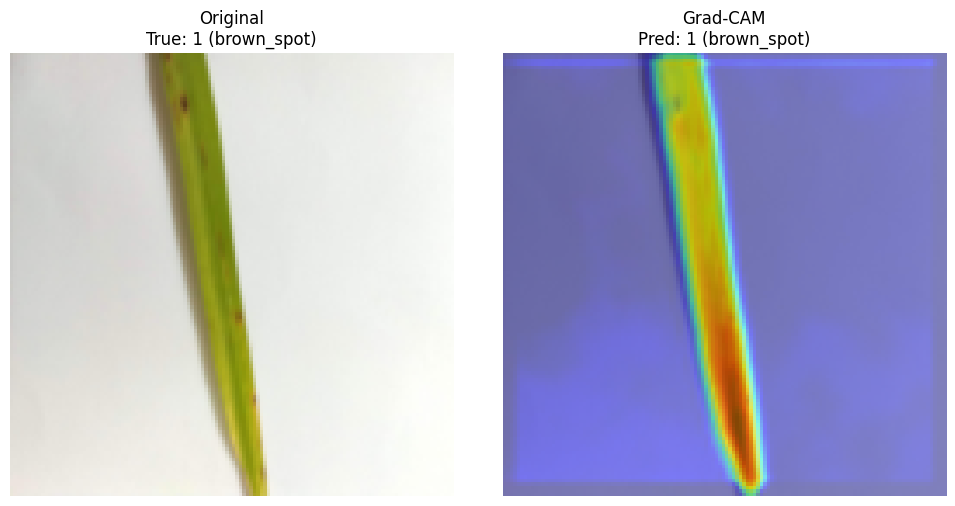

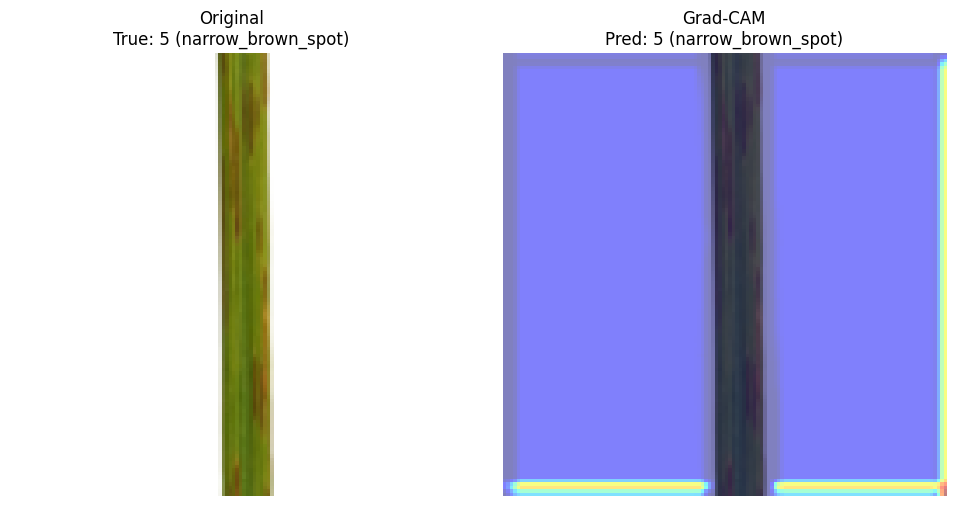

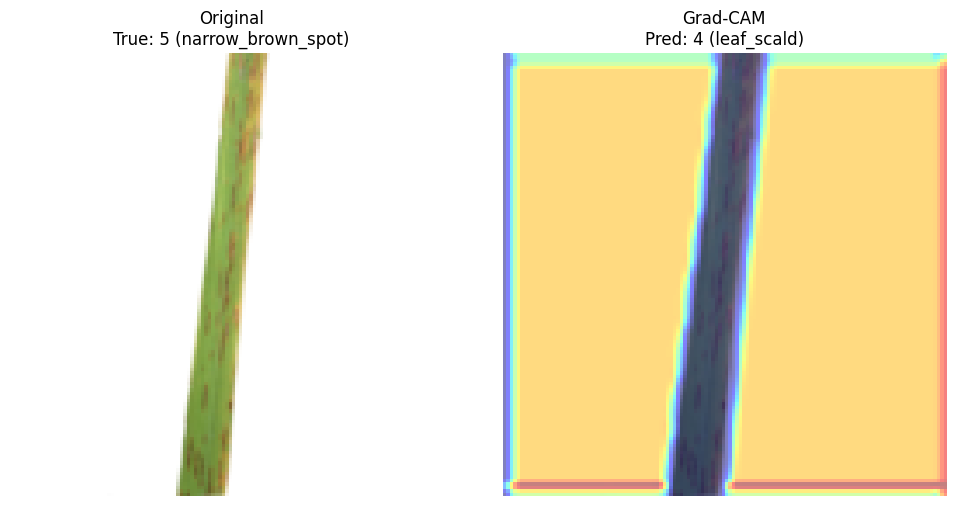

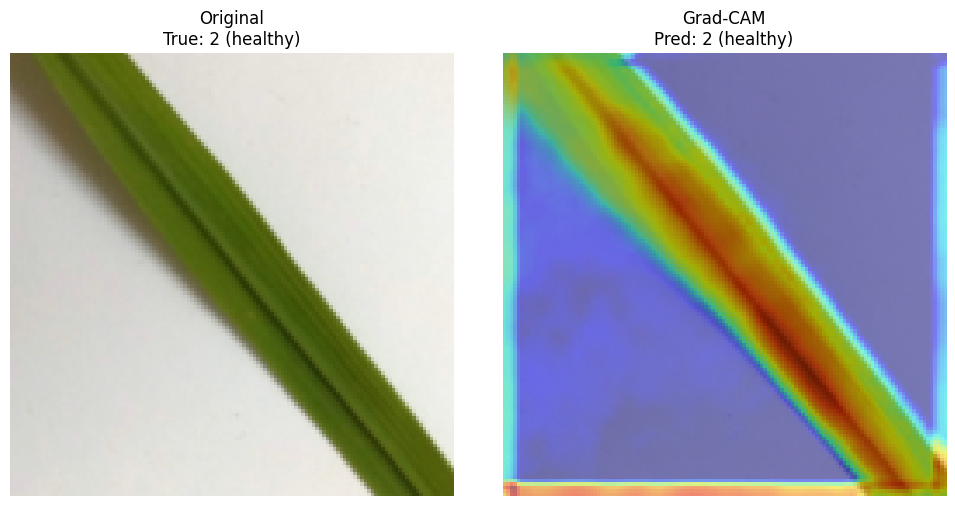

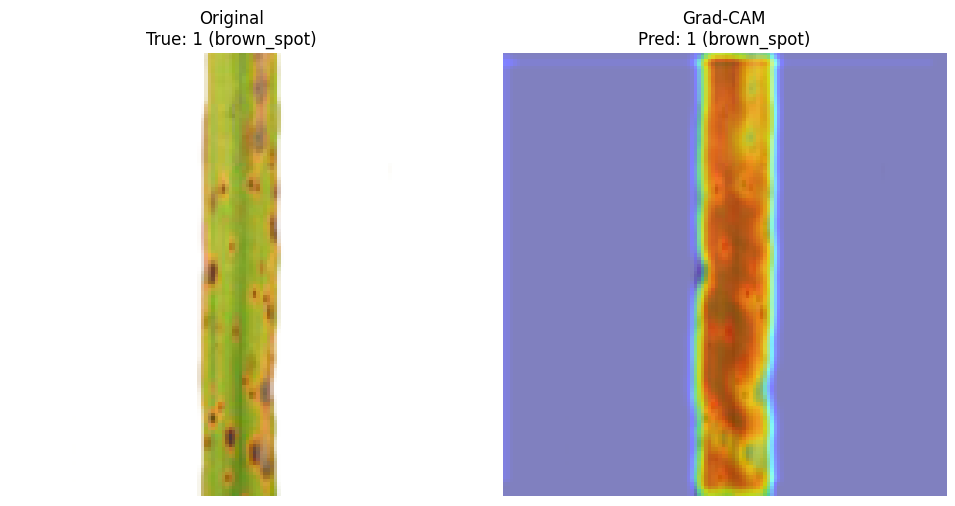

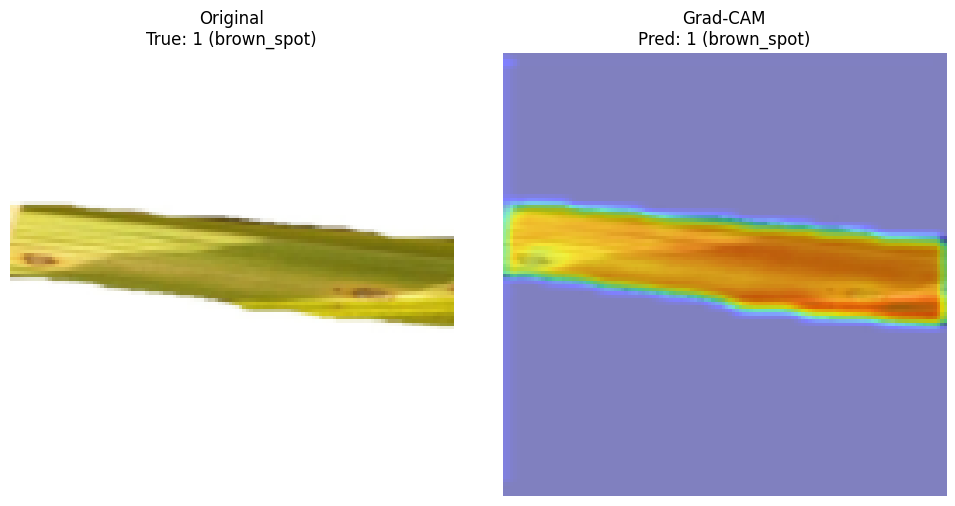

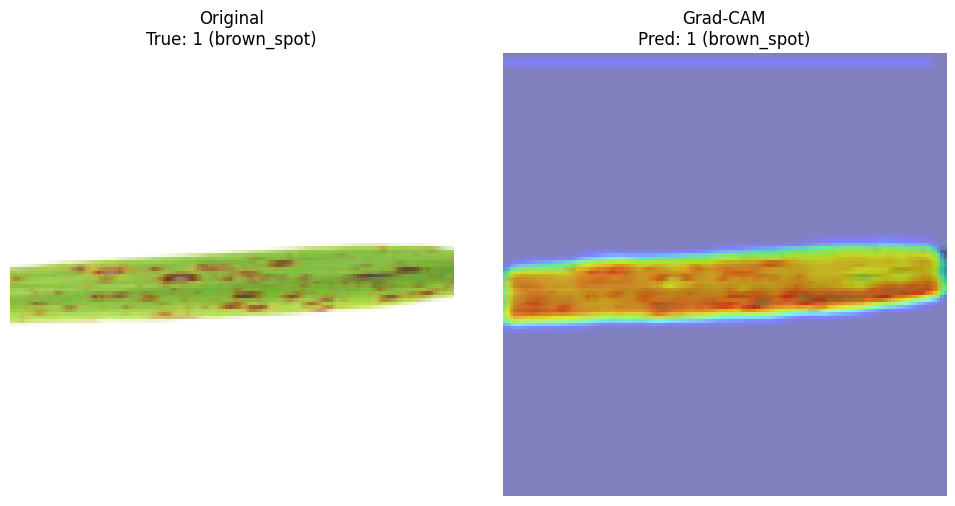

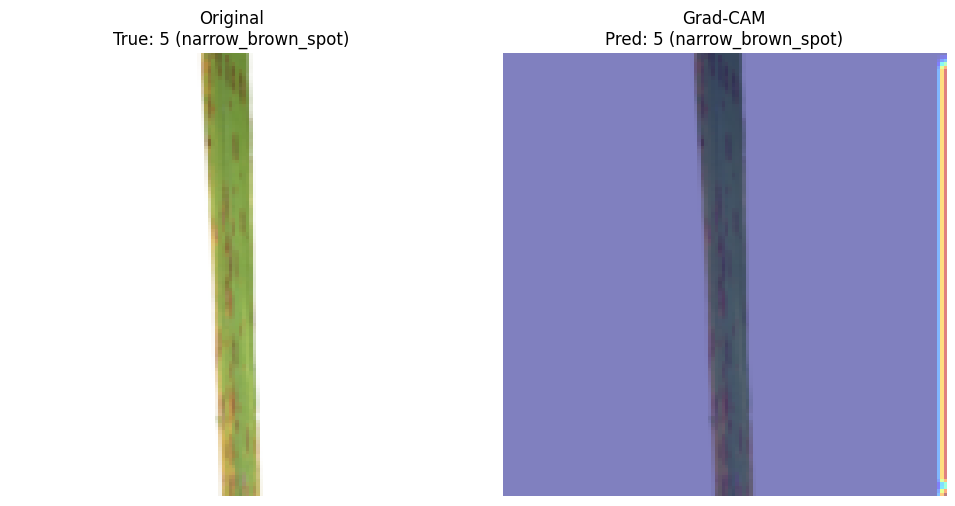

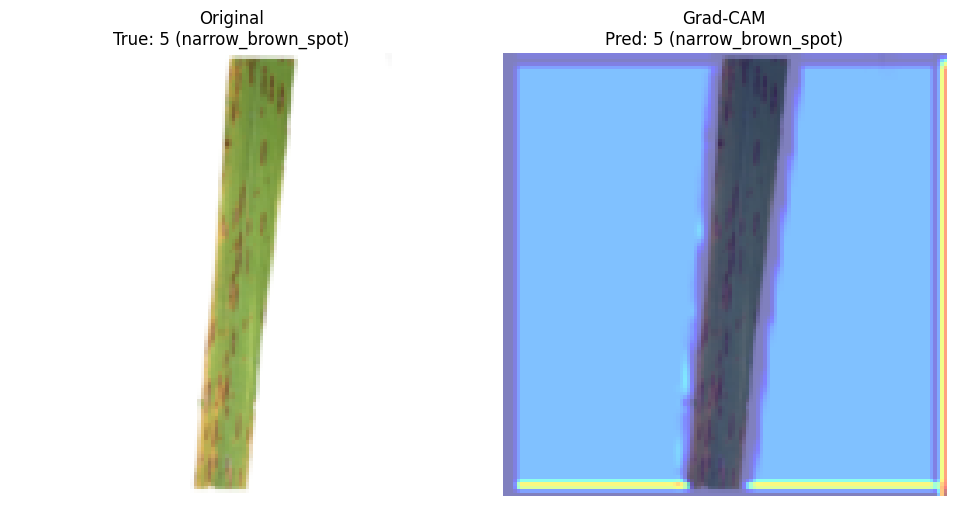

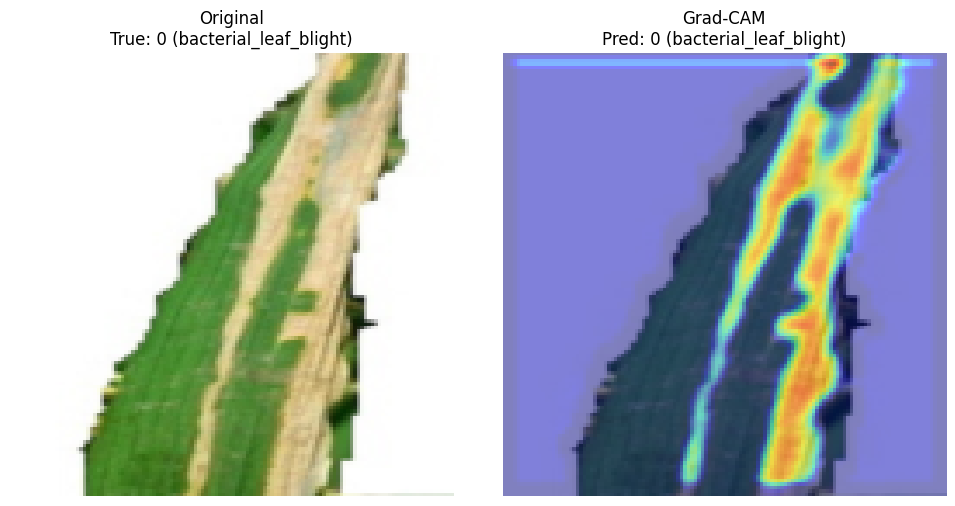

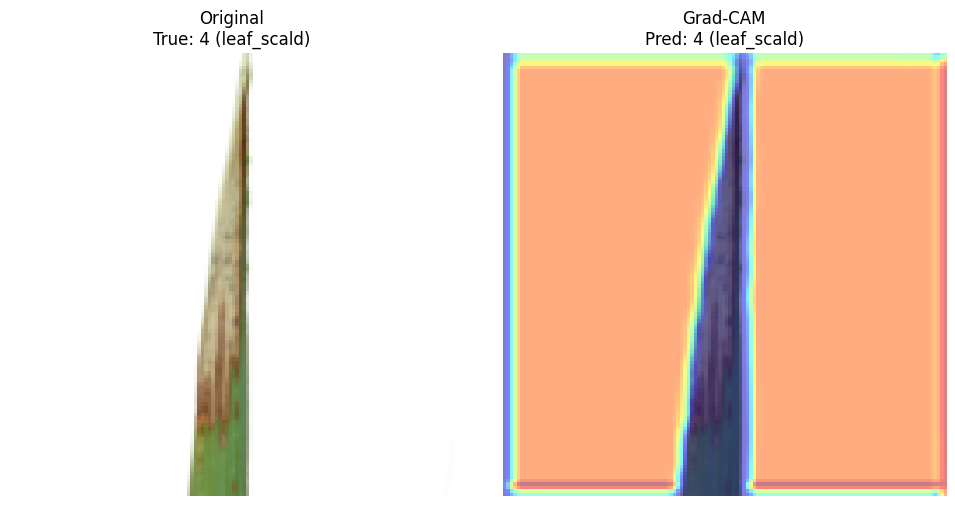

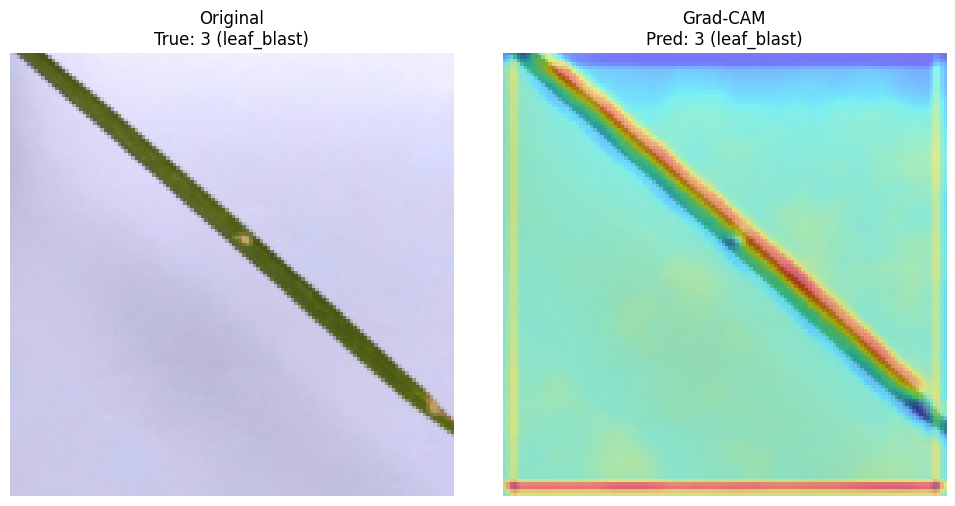

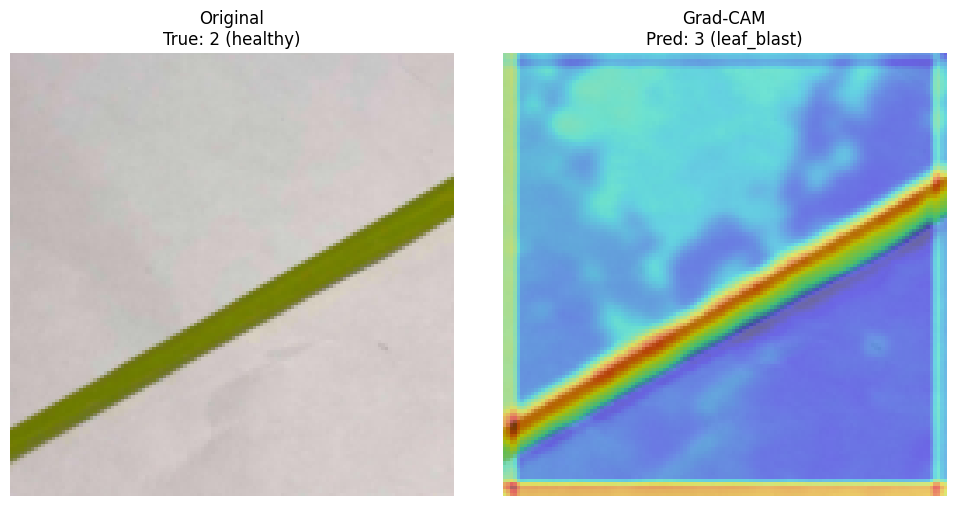

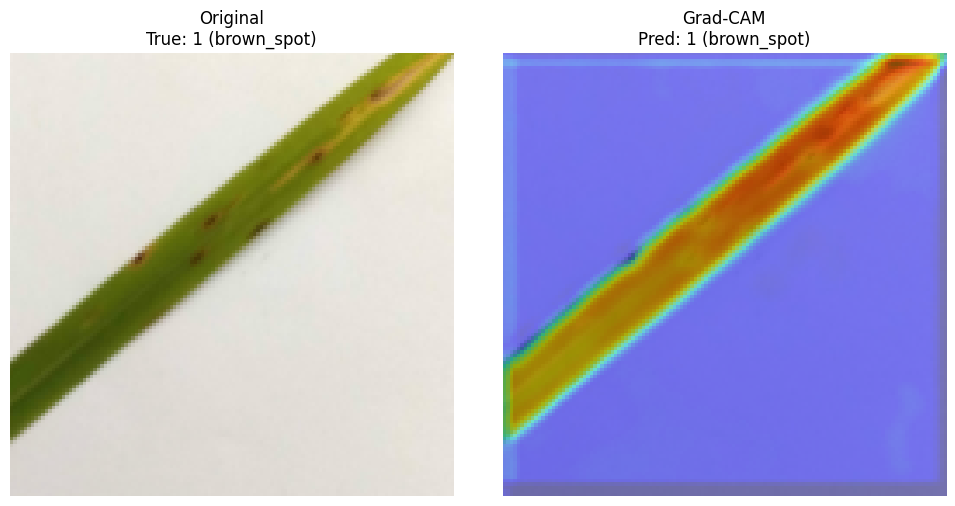

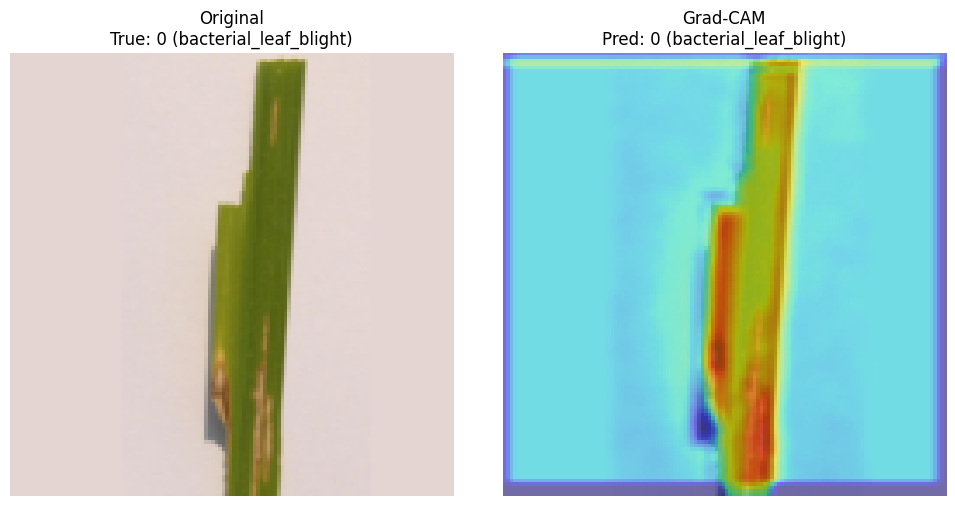

In [18]:
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# Pick N random indices from the validation dataset
num_images = 20  # Change this to any number you want
random_indices = random.sample(range(len(val_dataset)), num_images)

# Set model to eval
model.eval()

# Loop through selected images
for idx in random_indices:
    img, true_label = val_dataset[idx]
    input_tensor = img.unsqueeze(0).to(device)
    input_tensor.requires_grad_()

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax().item()

    # Generate Grad-CAM
    activation_map = cam_extractor(pred_class, output)[0]  # shape: (1, H, W)

    # Resize CAM to match image size
    cam = F.interpolate(activation_map.unsqueeze(0), size=img_size, mode='bilinear', align_corners=False)
    cam = cam.squeeze().cpu().numpy()

    # Convert image for display
    original_img = to_pil_image(img)

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(original_img)
    axes[0].set_title(f"Original\nTrue: {true_label} ({list(train_dataset.label_map.keys())[true_label]})")
    axes[0].axis("off")

    axes[1].imshow(original_img)
    axes[1].imshow(cam, cmap='jet', alpha=0.5)
    axes[1].set_title(f"Grad-CAM\nPred: {pred_class} ({list(train_dataset.label_map.keys())[pred_class]})")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


Saliency-MAP

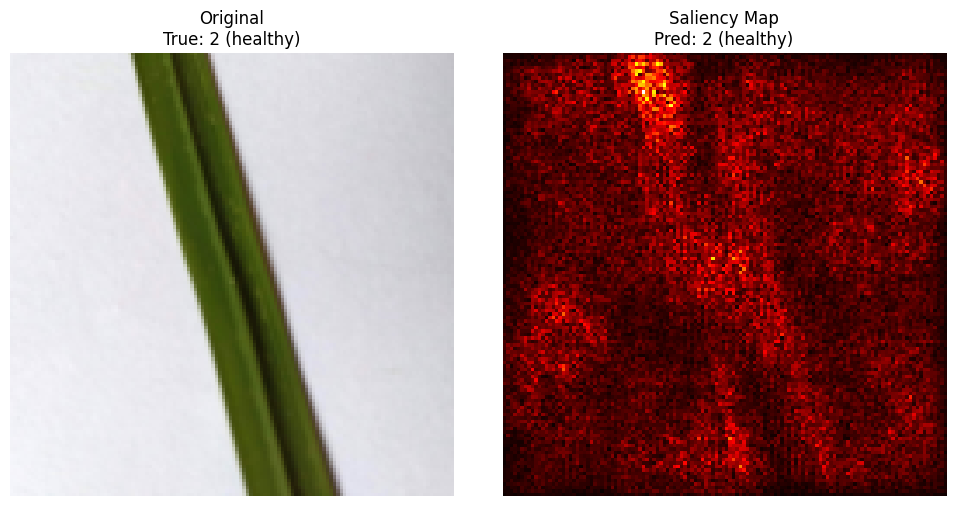

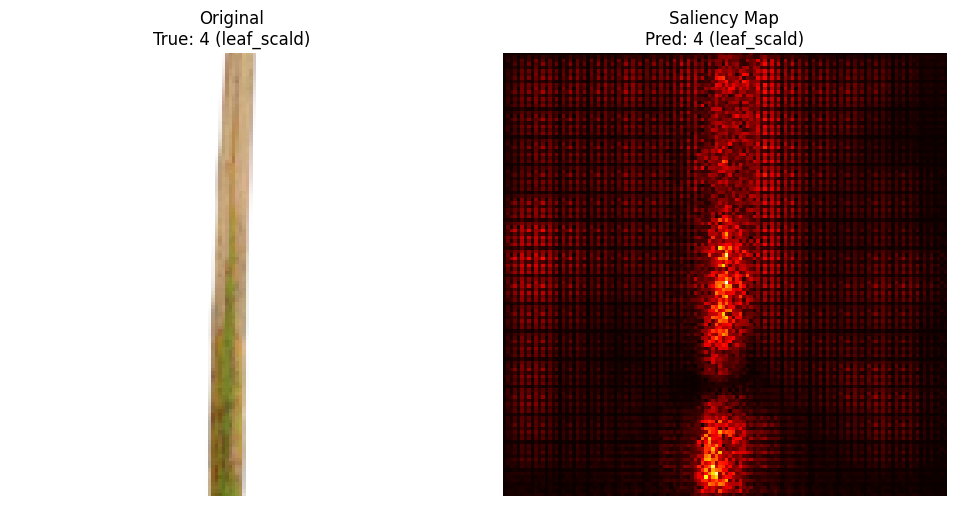

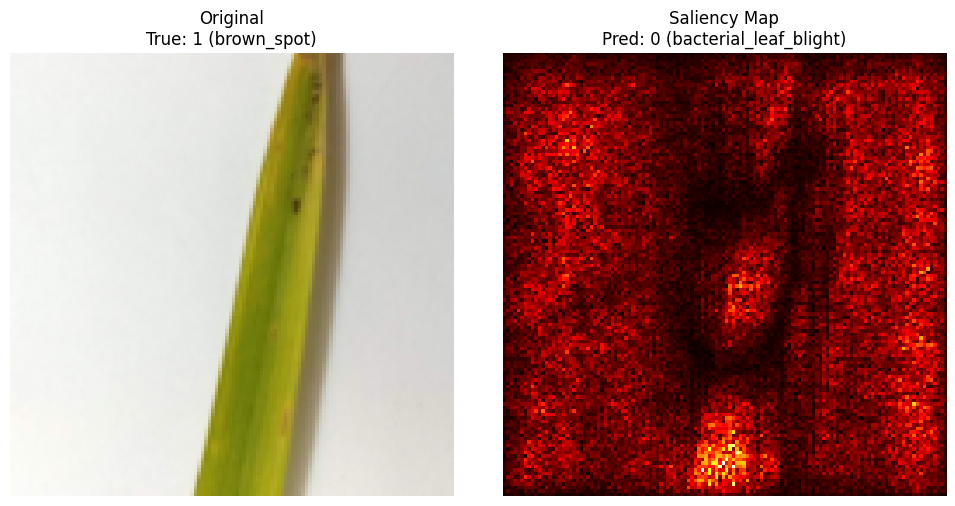

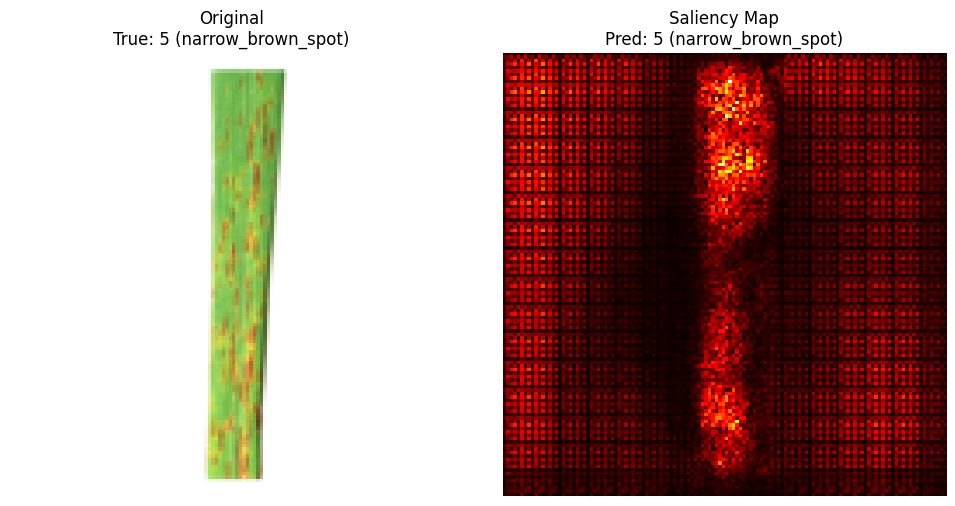

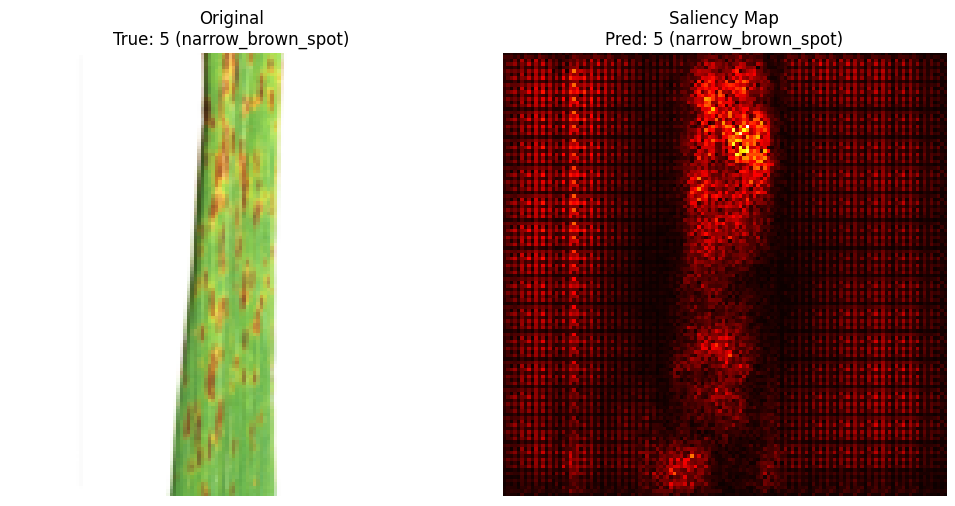

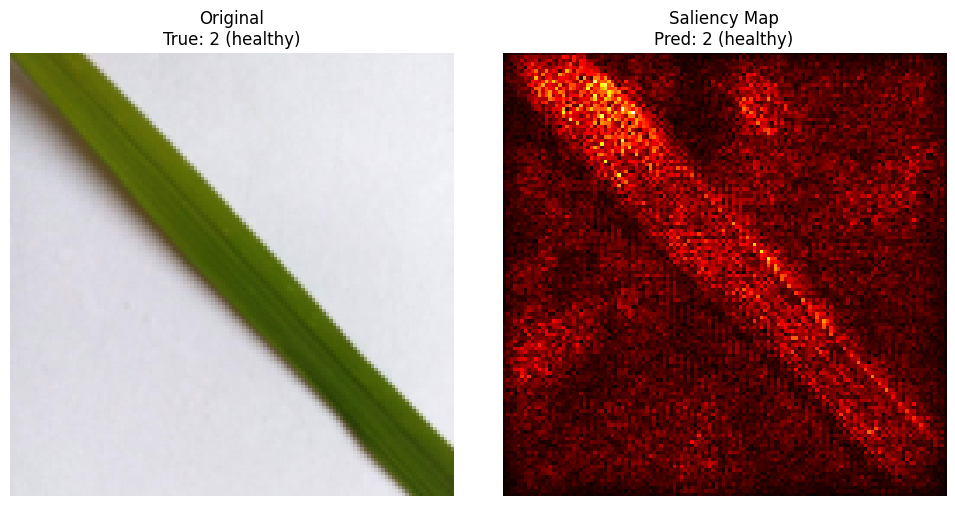

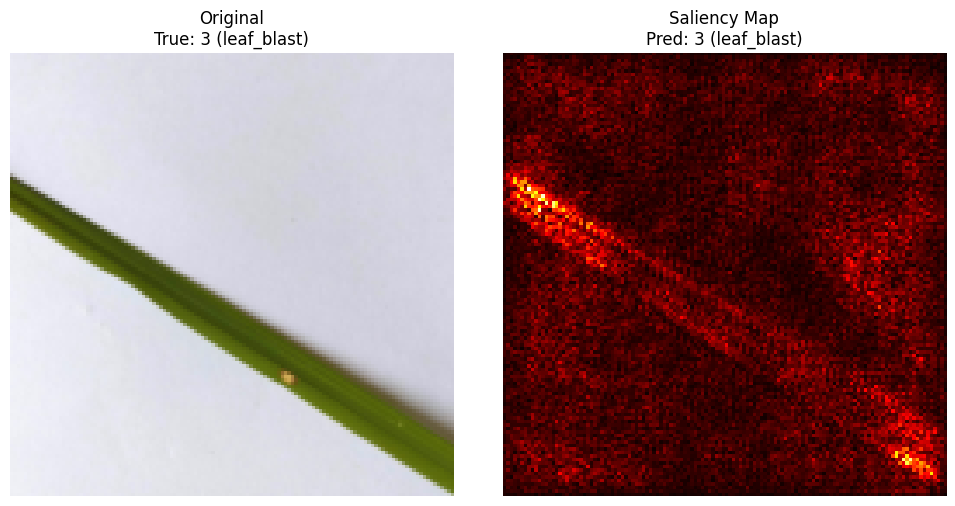

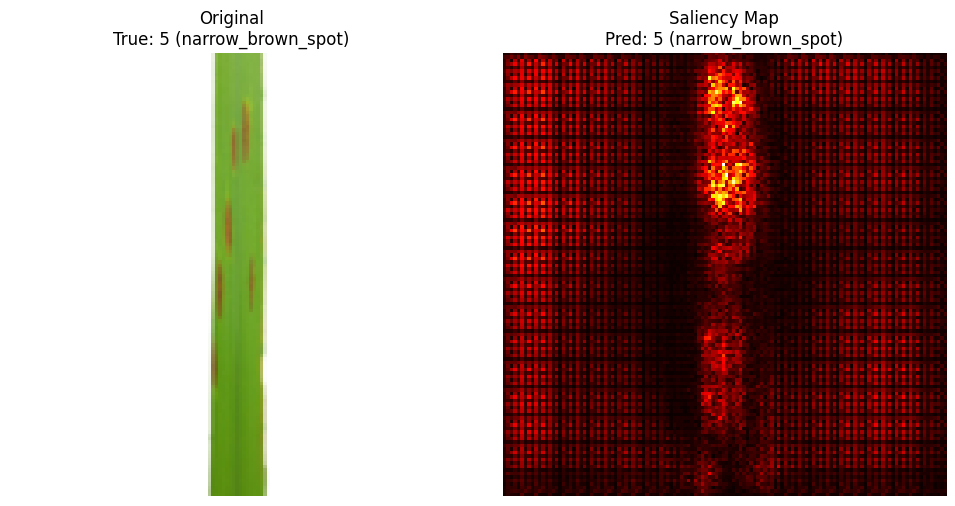

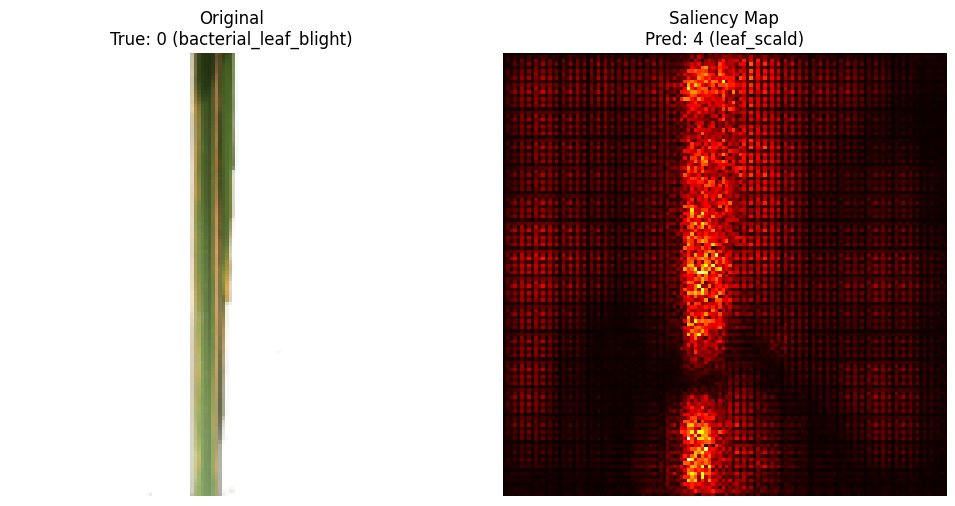

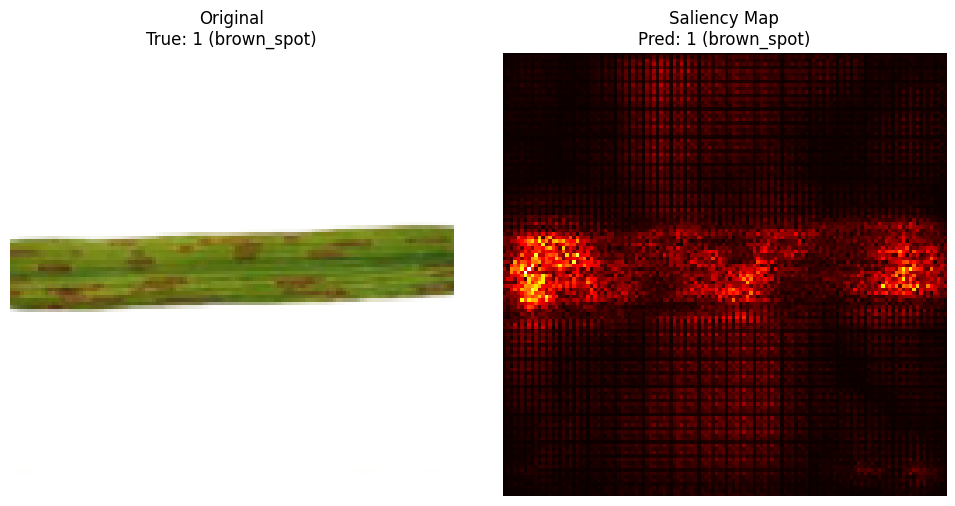

In [21]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import random

# Set model to eval
model.eval()

# Pick 5 random images from validation dataset
num_images = 10
indices = random.sample(range(len(val_dataset)), num_images)

for idx in indices:
    img, label = val_dataset[idx]
    input_tensor = img.unsqueeze(0).to(device)
    input_tensor.requires_grad_()

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax()

    # Zero gradients and backprop from predicted class score
    model.zero_grad()
    output[0, pred_class].backward()

    # Saliency computation
    saliency = input_tensor.grad.data.abs().squeeze()  # shape: (3, H, W)
    saliency_map = saliency.max(dim=0)[0].cpu().numpy()  # shape: (H, W)

    # Convert to image
    original_img = to_pil_image(img)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(original_img)
    axes[0].set_title(f"Original\nTrue: {label} ({list(train_dataset.label_map.keys())[label]})")
    axes[0].axis("off")
    
    axes[1].imshow(saliency_map, cmap='hot')
    axes[1].set_title(f"Saliency Map\nPred: {pred_class.item()} ({list(train_dataset.label_map.keys())[pred_class.item()]})")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

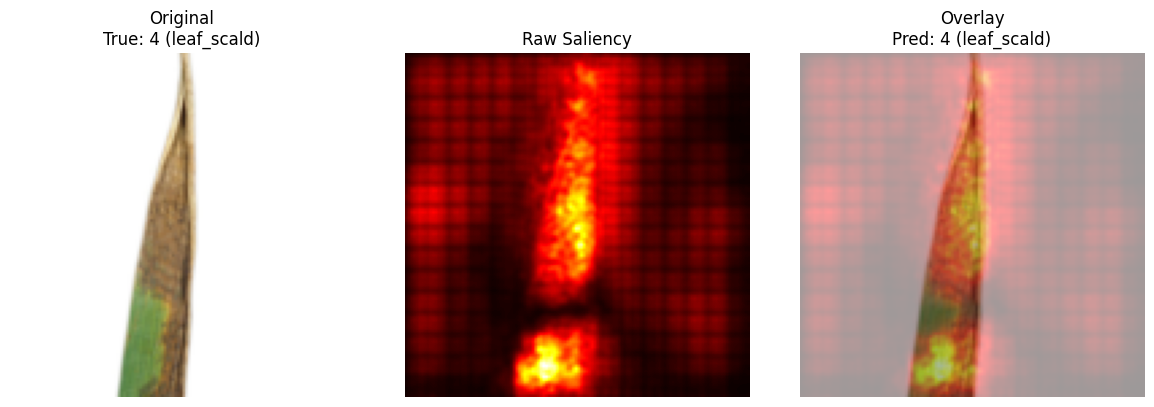

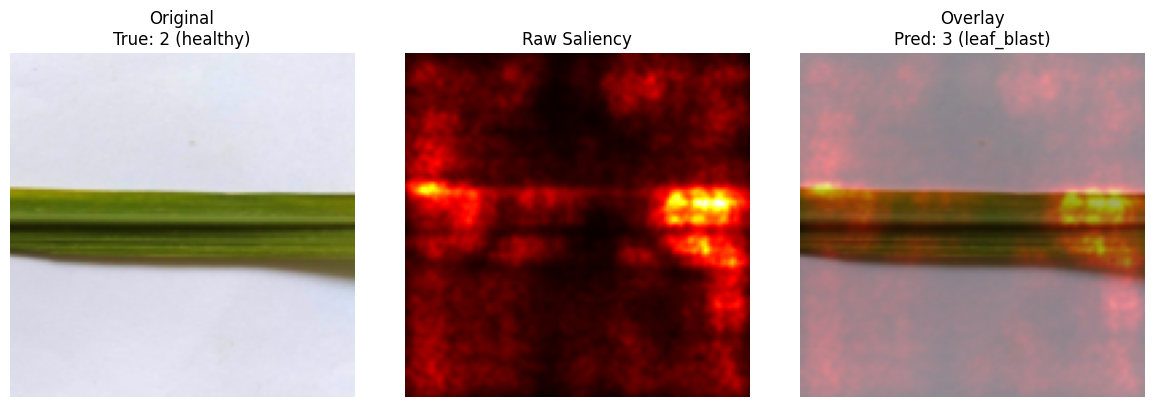

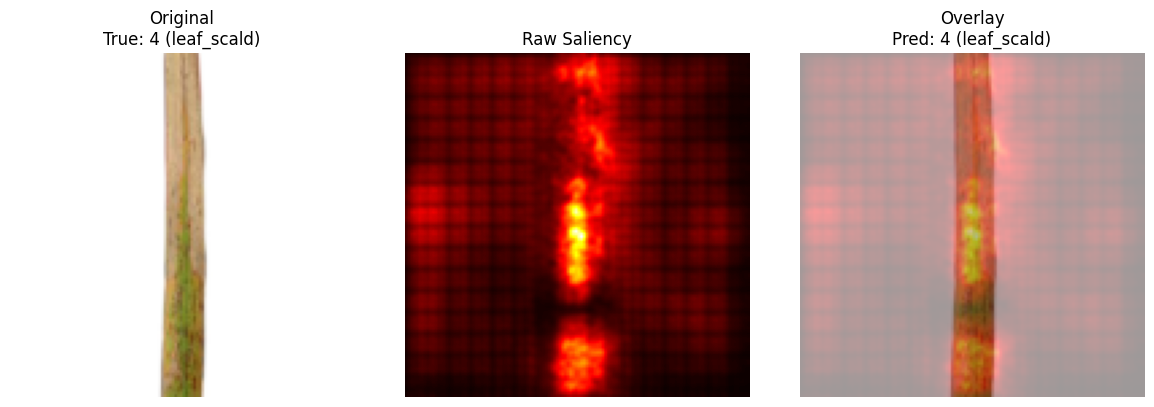

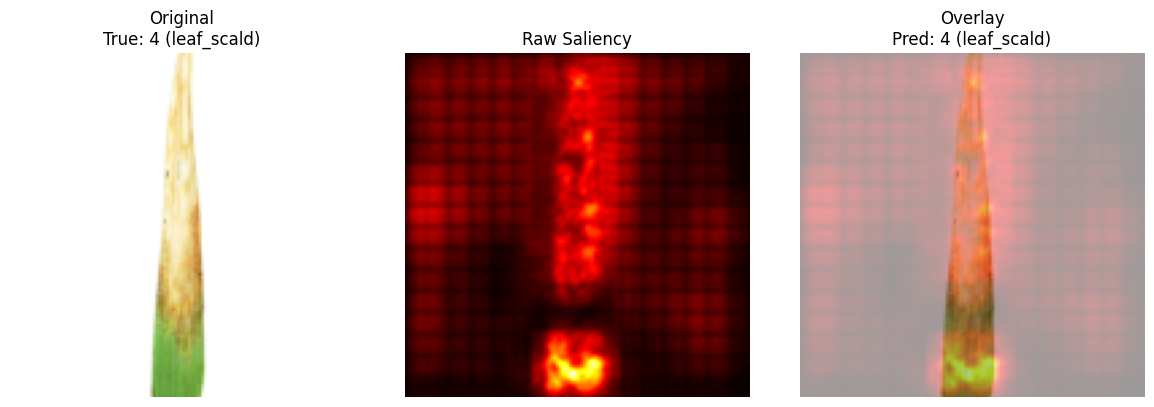

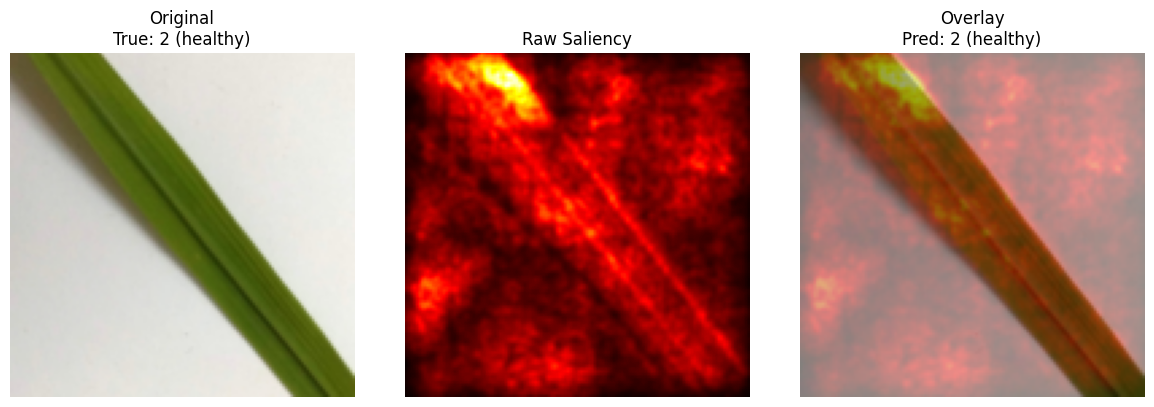

In [23]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image, to_tensor
from scipy.ndimage import gaussian_filter

model.eval()

indices = random.sample(range(len(val_dataset)), 5)

for idx in indices:
    img, label = val_dataset[idx]
    input_tensor = img.unsqueeze(0).to(device)
    input_tensor.requires_grad_()

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax()

    # Backward on predicted class
    model.zero_grad()
    output[0, pred_class].backward()

    # Raw saliency map
    saliency = input_tensor.grad.data.abs().squeeze()
    saliency_map = saliency.max(dim=0)[0].cpu().numpy()

    # Optional Gaussian smoothing
    saliency_map = gaussian_filter(saliency_map, sigma=1)

    # Normalize saliency
    saliency_map -= saliency_map.min()
    saliency_map /= saliency_map.max()

    # Convert original image
    original_img = to_pil_image(img)
    img_tensor = to_tensor(original_img)

    # Create heatmap
    heatmap = plt.get_cmap("hot")(saliency_map)[:, :, :3]  # Remove alpha
    heatmap_tensor = torch.tensor(heatmap).permute(2, 0, 1)

    # Overlay
    overlay = 0.6 * img_tensor + 0.4 * heatmap_tensor
    overlay = torch.clamp(overlay, 0, 1)

    # Plot all three
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(original_img)
    axes[0].set_title(f"Original\nTrue: {label} ({list(train_dataset.label_map.keys())[label]})")
    axes[0].axis("off")

    axes[1].imshow(saliency_map, cmap='hot')
    axes[1].set_title("Raw Saliency")
    axes[1].axis("off")

    axes[2].imshow(to_pil_image(overlay))
    axes[2].set_title(f"Overlay\nPred: {pred_class.item()} ({list(train_dataset.label_map.keys())[pred_class.item()]})")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
